In [1]:
# !pip install lightgbm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])
df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [3]:
#EDA

In [4]:
df.describe(include='all')

,user_id,order_completed_at,cart
count,3.123064e+06,3123064,3.123064e+06
mean,7.253373e+03,2020-04-09 01:17:00.182836992,2.273235e+02
min,0.000000e+00,2015-03-22 09:25:46,0.000000e+00
25%,2.884000e+03,2020-02-03 06:03:43,4.200000e+01
50%,6.055000e+03,2020-05-19 06:35:20,1.460000e+02
75%,1.117200e+04,2020-07-14 04:50:22,3.990000e+02
max,1.999900e+04,2020-09-03 23:45:45,8.800000e+02
std,5.337838e+03,NaN,2.112867e+02


In [5]:
print(df.shape)
print(df.isna().sum().sum())

(3123064, 3)
0


In [6]:
categs = df['cart'].value_counts()
df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


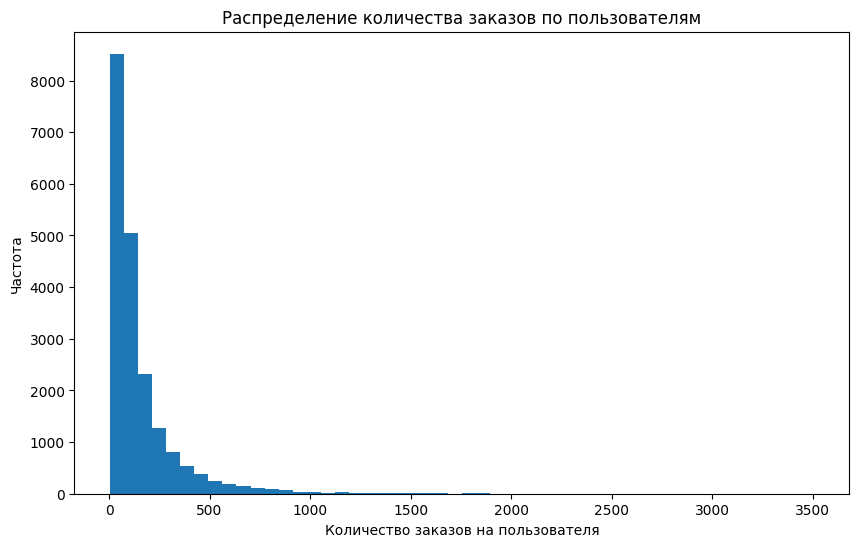

In [7]:
order_counts = df['user_id'].value_counts()
plt.figure(figsize=(10, 6))
plt.hist(order_counts, bins=50)
plt.xlabel('Количество заказов на пользователя')
plt.ylabel('Частота')
plt.title('Распределение количества заказов по пользователям')
plt.show()

In [8]:
# Создадим тестовую выборку: для каждого пользователя будут только фактические покупки из его последнего заказа 

df = df.sort_values(['user_id', 'order_completed_at'])

last_orders = df.groupby('user_id')['order_completed_at'].max().reset_index().rename(columns={'order_completed_at': 'last_order_completed_at'})

df = df.merge(last_orders, on='user_id', how='left')
df['is_test'] = (df['order_completed_at'] == df['last_order_completed_at']).astype(int)

train = df[df['is_test'] == 0].copy()
val  = df[df['is_test'] == 1].copy()

print(f"Train shape: {train.shape}")
print(f"Test shape:  {val.shape}")

Train shape: (2841987, 5)
Test shape:  (281077, 5)


In [9]:
val.head()

,user_id,order_completed_at,cart,last_order_completed_at,is_test
33,0,2020-09-02 07:38:25,803,2020-09-02 07:38:25,1
34,0,2020-09-02 07:38:25,170,2020-09-02 07:38:25,1
35,0,2020-09-02 07:38:25,84,2020-09-02 07:38:25,1
36,0,2020-09-02 07:38:25,61,2020-09-02 07:38:25,1
37,0,2020-09-02 07:38:25,440,2020-09-02 07:38:25,1


In [10]:
train = train.drop(columns=['is_test', 'last_order_completed_at'])
val  = val.drop(columns=['is_test', 'last_order_completed_at'])
train_with_dates = train.copy()
val_with_dates = val.copy()
train_pos = train.drop(columns=['order_completed_at'])
val_pos = val.drop(columns=['order_completed_at'])
train.head()

,user_id,order_completed_at,cart
0,0,2020-07-19 09:59:17,20
1,0,2020-07-19 09:59:17,82
2,0,2020-07-19 09:59:17,441
3,0,2020-07-19 09:59:17,57
4,0,2020-07-19 09:59:17,14


In [11]:
# Negative Sampling for Validation
all_carts_train = train_pos.drop_duplicates()
train_pos['target'] = 1
val_pos = val_pos.drop_duplicates()
val_pos['target'] = 1

In [12]:
negative_val = all_carts_train.merge(val_pos, on=['user_id', 'cart'], how='left', indicator=True)
negative_val = negative_val[negative_val['_merge'] == 'left_only'].drop(columns=['_merge', 'target'])
negative_val['target'] = 0
val_full = pd.concat([val_pos, negative_val], ignore_index=True)

In [13]:
val_full.describe()

,user_id,cart,target
count,1.117600e+06,1.117600e+06,1.117600e+06
mean,8.653122e+03,2.569703e+02,2.515005e-01
std,5.624315e+03,2.213021e+02,4.338758e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.787000e+03,6.100000e+01,0.000000e+00
50%,7.990000e+03,1.970000e+02,0.000000e+00
75%,1.322400e+04,4.030000e+02,1.000000e+00
max,1.999900e+04,8.800000e+02,1.000000e+00


In [14]:
unique_users = train_pos['user_id'].unique()
unique_carts = train_pos['cart'].unique()

negative_count = 100
negative_samples = []

user_to_carts = train_pos.groupby('user_id')['cart'].apply(set).to_dict()

for user in unique_users:
    seen_carts = user_to_carts[user]
    negative_pool = list(set(unique_carts) - seen_carts)
    if len(negative_pool) >= negative_count:
        sampled_neg = np.random.choice(negative_pool, size=negative_count, replace=False)
        
    for cart in sampled_neg:
        negative_samples.append({'user_id': user, 'cart': cart, 'target': 0})

train_full = pd.concat([train_pos, pd.DataFrame(negative_samples)], ignore_index=True)
train_full['target'].value_counts()

target
1    2841987
0    2000000
Name: count, dtype: int64

In [15]:
print(train_full['user_id'].value_counts())

user_id
380      3594
105      2910
84       2691
3918     2648
1156     2456
         ... 
15773     102
18528     102
3844      102
14620     102
19936     102
Name: count, Length: 20000, dtype: int64


In [16]:
print(train_pos.shape)
print(train_with_dates.shape)
print(train_full.shape)

(2841987, 3)
(2841987, 3)
(4841987, 3)


In [17]:
user_cart_count = (train_with_dates.groupby(['user_id', 'cart']).size().reset_index(name='user_cart_count')) # how much user ordered each cart
cart_popularity = (train_with_dates.groupby(['cart'])['user_id'].nunique()).reset_index(name='cart_popularity') # how much people ordered each cart
total_users = train_with_dates['user_id'].nunique()
cart_popularity['cart_popularity'] = cart_popularity['cart_popularity'] / total_users

train_full = train_full.merge(user_cart_count, how='left', on=['user_id', 'cart'])
train_full = train_full.merge(cart_popularity, how='left', on='cart')
train_full['user_cart_count'] = train_full['user_cart_count'].fillna(0)

val_full = val_full.merge(user_cart_count, how='left', on=['user_id', 'cart'])
val_full = val_full.merge(cart_popularity, how='left', on='cart')
val_full['user_cart_count'] = val_full['user_cart_count'].fillna(0)

train_full.head()

,user_id,cart,target,user_cart_count,cart_popularity
0,0,20,1,1.0,0.29530
1,0,82,1,2.0,0.37465
2,0,441,1,2.0,0.26310
3,0,57,1,2.0,0.81680
4,0,14,1,2.0,0.76365


In [18]:
# Make baseline-model results

In [19]:
features = ['user_id', 'cart', 'user_cart_count', 'cart_popularity']
X_train = train_full[features]
y_train = train_full['target']
X_val = val_full[features]
y_val = val_full['target']

model = lgb.LGBMClassifier(
    objective='binary',
    random_state=42,
    n_estimators=500,
    learning_rate=0.5,
    verbose=-1 
)

model.fit(
    X_train,
    y_train,
    categorical_feature=['user_id', 'cart'],
    eval_set=[(X_val, y_val)]
)

LGBMClassifier(learning_rate=0.5, n_estimators=500, objective='binary',
               random_state=42, verbose=-1)

In [20]:
y_pred = model.predict(X_val)

f1 = f1_score(y_val, y_pred)
print(f'Baseline F1-score:', f1)

Baseline F1-score: 0.2967906329580766


In [21]:
# Feature Engineering